In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the number of samples
n_samples = 1000

# Generate the data
data = {
    'satisfaction_level': np.round(np.random.uniform(0, 1, n_samples), 2),
    'last_evaluation': np.round(np.random.uniform(0, 1, n_samples), 2),
    'number_project': np.random.randint(1, 7, n_samples),
    'average_montly_hours': np.random.randint(90, 310, n_samples),
    'time_spend_company': np.random.randint(2, 11, n_samples),
    'Work_accident': np.random.randint(0, 2, n_samples),
    'left': np.random.randint(0, 2, n_samples),
    'promotion_last_5years': np.random.randint(0, 2, n_samples),
    'sales': np.random.choice(['sales', 'accounting', 'hr', 'technical', 'support', 'management', 'IT', 'product_mng', 'marketing', 'RandD'], n_samples),
    'salary': np.random.choice(['low', 'medium', 'high'], n_samples)
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df.head()


## 1. Exploratory Data Analysis (EDA)

To understand what factors contributed most to employee turnover, we can analyze the correlation and visualize the relationships between the features and the target variable.

In [53]:
# Display basic statistics of the data
df.describe(include='all')

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000,1000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hr,high
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115,342
mean,0.489260,0.516620,3.429000,200.420000,6.045000,0.489000,0.483000,0.48000,NaN,NaN
std,0.290689,0.290864,1.697599,63.849843,2.586439,0.500129,0.499961,0.49985,NaN,NaN
min,0.000000,0.000000,1.000000,90.000000,2.000000,0.000000,0.000000,0.00000,NaN,NaN
25%,0.240000,0.270000,2.000000,143.750000,4.000000,0.000000,0.000000,0.00000,NaN,NaN
50%,0.485000,0.520000,3.000000,200.500000,6.000000,0.000000,0.000000,0.00000,NaN,NaN
75%,0.740000,0.780000,5.000000,256.000000,8.000000,1.000000,1.000000,1.00000,NaN,NaN


In [54]:
# Check for missing values
df.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

                       satisfaction_level  last_evaluation  number_project  \
satisfaction_level                   1.00             0.05            0.04   
last_evaluation                      0.05             1.00            0.01   
number_project                       0.04             0.01            1.00   
average_montly_hours                 0.06             0.00            0.01   
time_spend_company                  -0.02            -0.03           -0.06   
Work_accident                       -0.06             0.01           -0.01   
left                                -0.05             0.02            0.02   
promotion_last_5years                0.03            -0.04           -0.03   

                       average_montly_hours  time_spend_company  \
satisfaction_level                     0.06               -0.02   
last_evaluation                        0.00               -0.03   
number_project                         0.01               -0.06   
average_montly_hours         

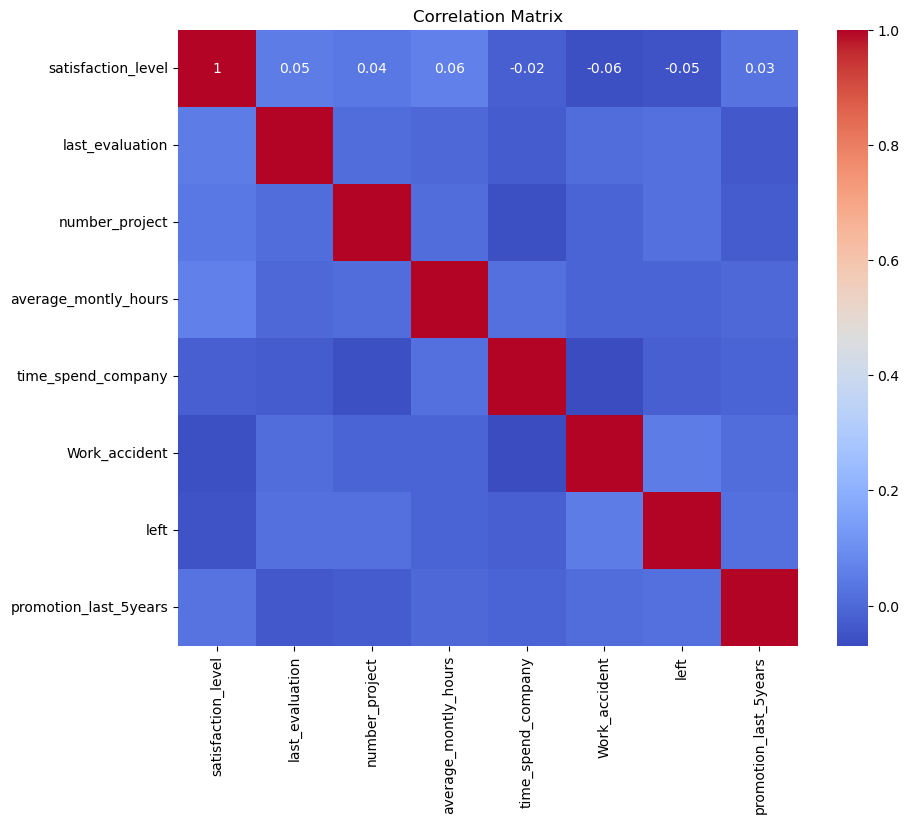

In [55]:
# Correlation matrix
cols = df.columns 
df1 = df[cols[:-2]] 
correlation_matrix = df1.corr().round(2)
print(correlation_matrix)

# Heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

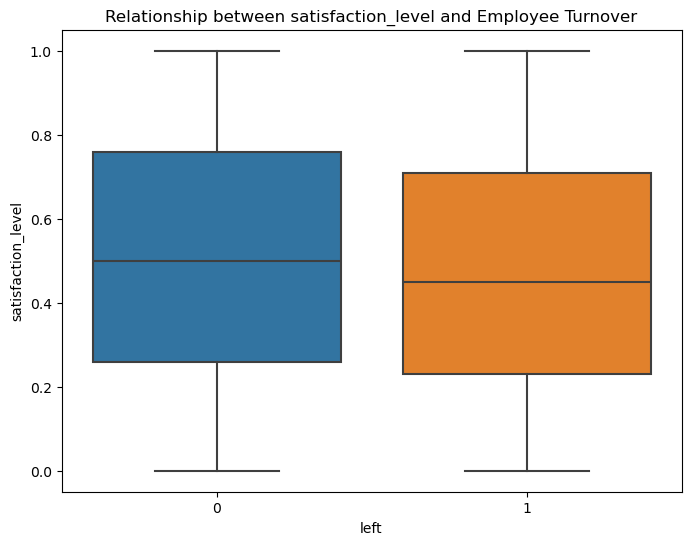

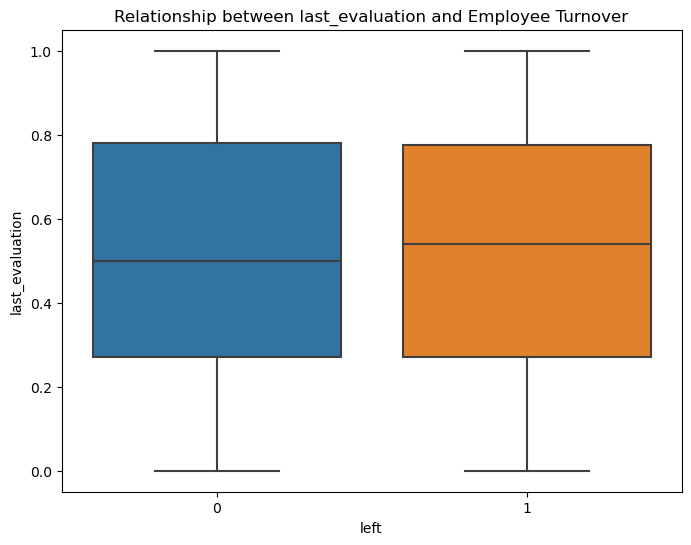

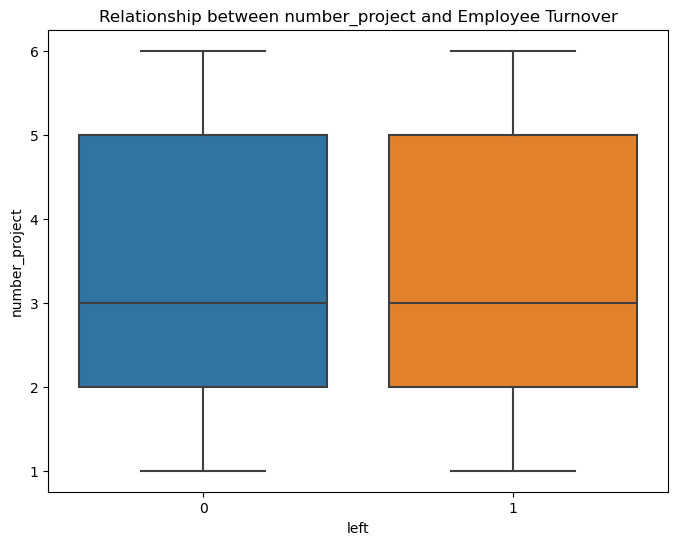

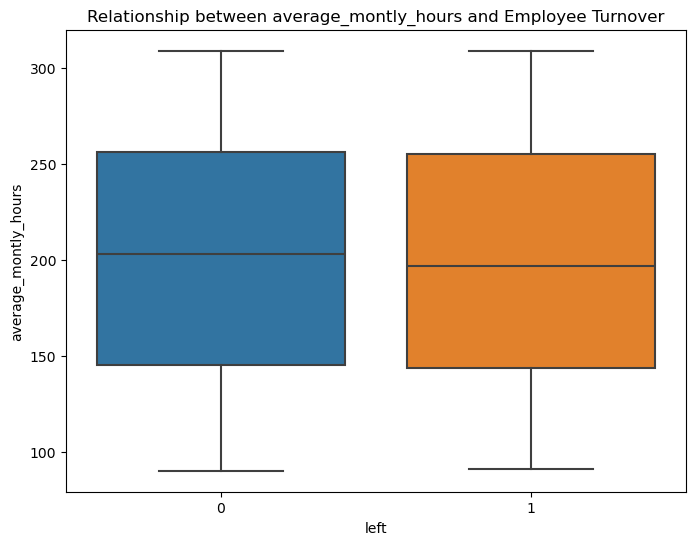

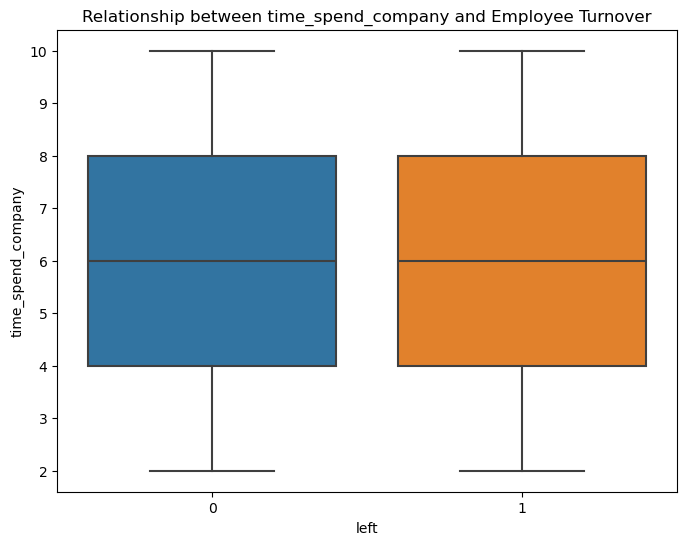

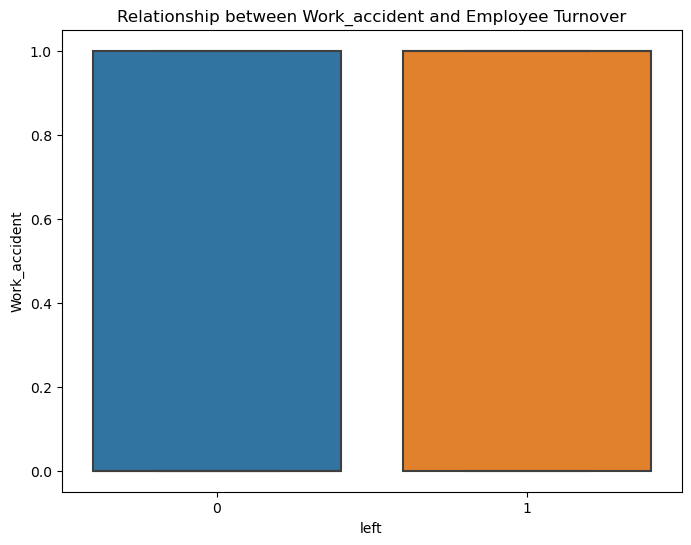

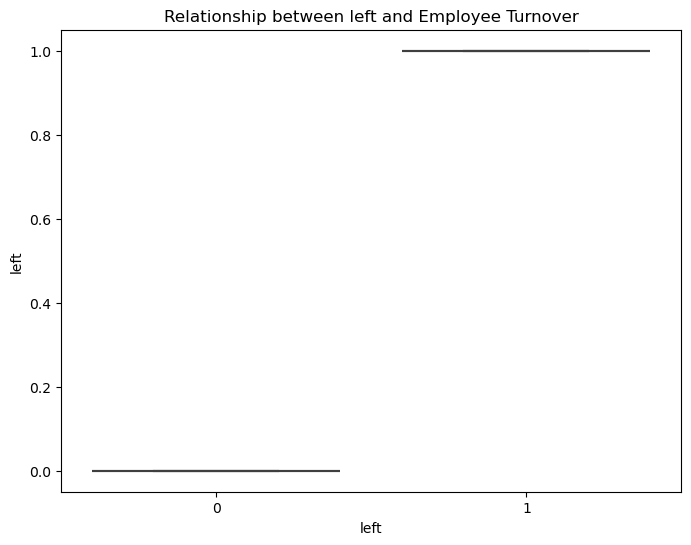

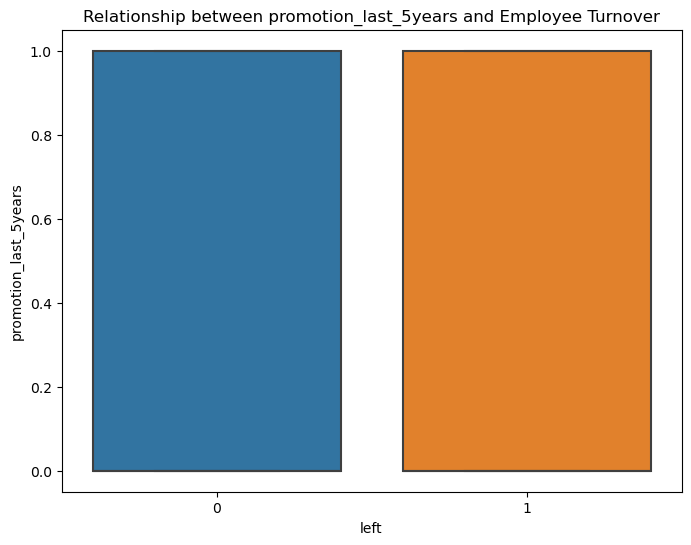

In [56]:
# Separate categorical and numerical variables
cols = list(df.columns)
categorical_vars = cols[-2:] #['sales', 'salary']
numerical_vars = df.drop(columns=categorical_vars).columns

# Boxplots to visualize the relationship between 'left' and numeric features
for column in numerical_vars:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='left', y=column, data=df)
    plt.title(f'Relationship between {column} and Employee Turnover')
    plt.show()

### Distribution Plot 


/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


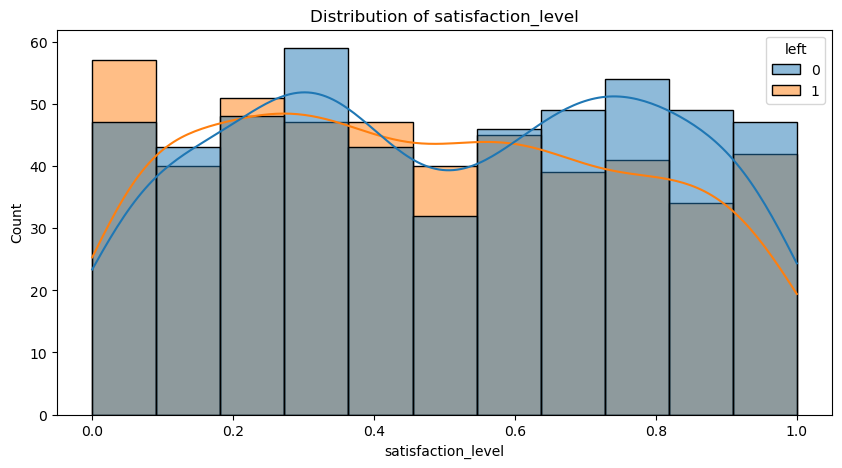

/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


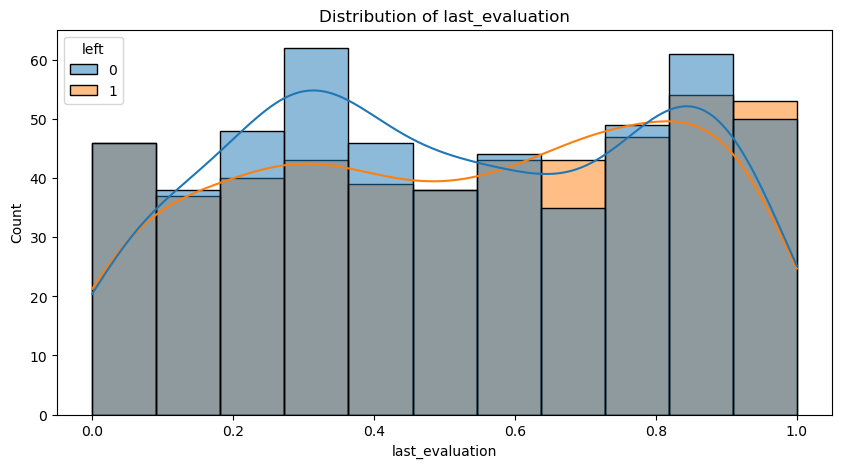

/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/sit

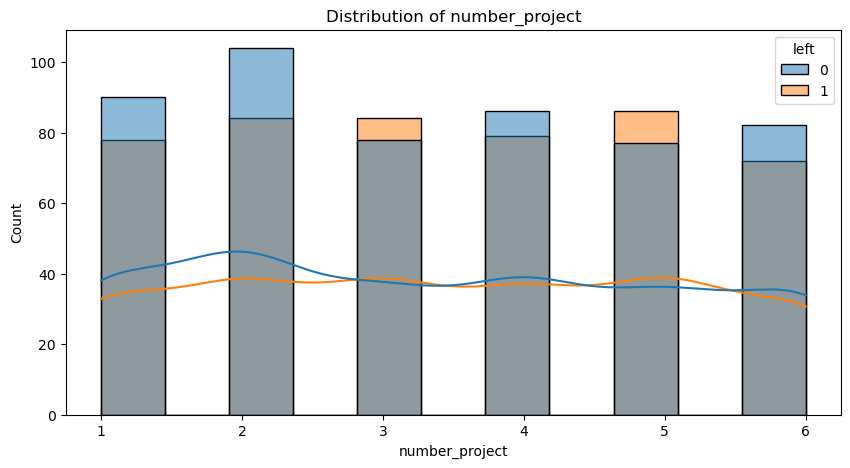

/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/sit

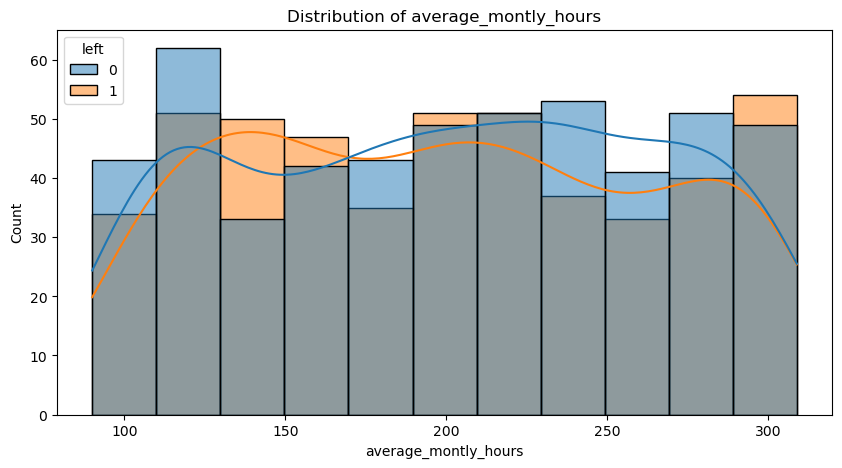

/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/sit

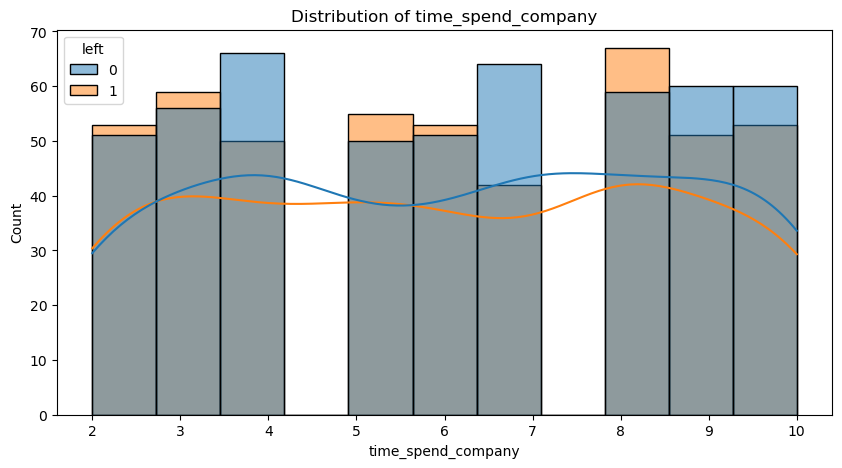

/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/sit

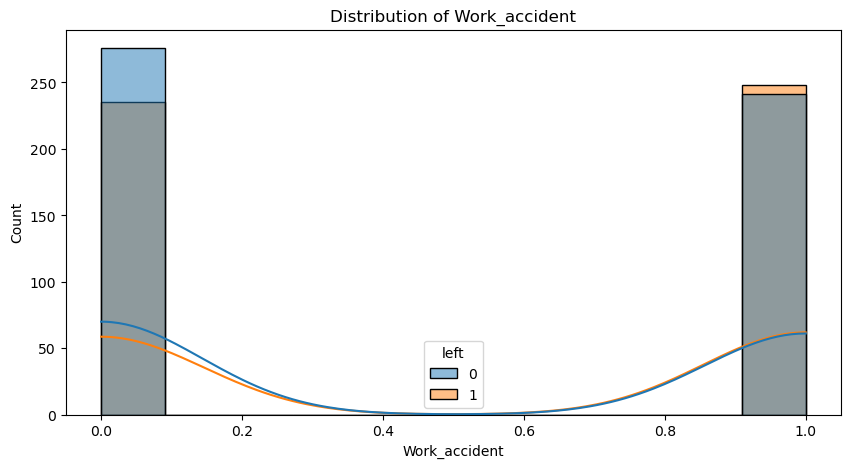

/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/sit

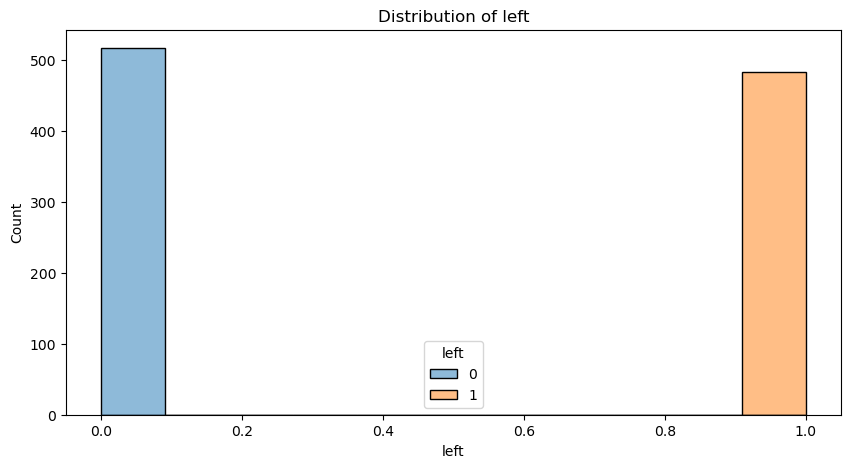

/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/sit

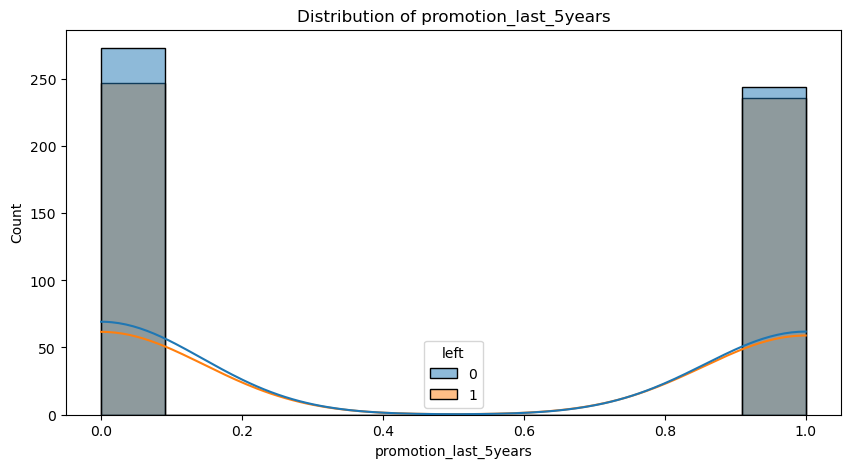

In [57]:
# Create a function to plot distribution
def histplot_employee_by(feature, df, show_turnover=True, show_kde=True):
    plt.figure(figsize=(8, 4))
    if show_turnover:
        # sns.histplot(x=feature, hue='left',data=df,  kde=show_kde, bins=15, palette='Set2')
        # sns.histplot(x=feature, hue='left', data=df, bins=15, palette='Set2')
        sns.histplot(x=feature, hue='left', data=df,  bins=15, palette='Set2')
        plt.legend(title='Employee Status', labels=['Left', 'Stayed'])
    else:
        sns.histplot(x=feature, data=df, kde=show_kde, bins=15)
    plt.title(f'Distribution of Employees based on {feature}')
    # plt.xlabel(f'Number of {feature}')
    plt.ylabel('Count of Employees')
    plt.show() 
    
# Distribution of Numerical Features and turnover
for feature in numerical_vars:
    plt.figure(figsize=(10, 5))
    # sns.histplot(df[feature], kde=True)
    sns.histplot(x=feature, hue='left',data=df,  kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()



/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


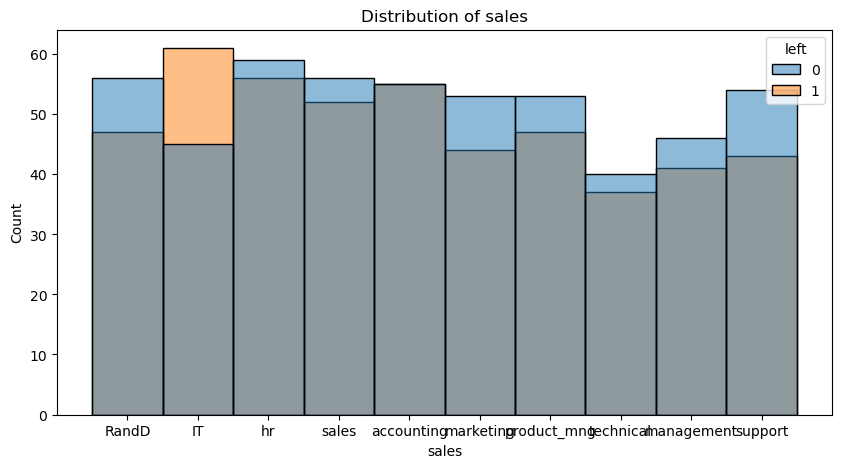

/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/AIMLbootcamp/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


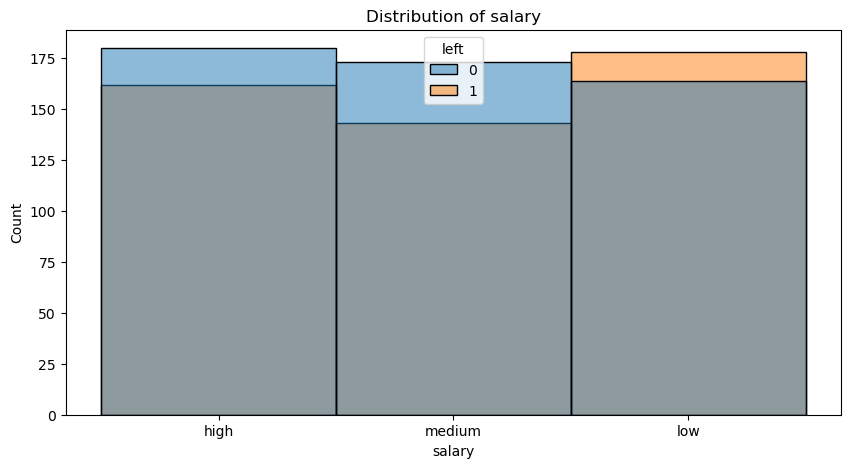

In [58]:
# # Plot categorical features
# for feature in categorical_vars:
#     plt.figure(figsize=(10, 5))
#     sns.countplot(x=feature, data=df)
#     plt.title(f'Distribution of {feature}')
#     plt.show()

# Plot categorical features and turnover
for feature in categorical_vars:
    plt.figure(figsize=(10, 5))
    sns.histplot(x=feature, hue='left',data=df)
    plt.title(f'Distribution of {feature}')
    plt.show() 
       

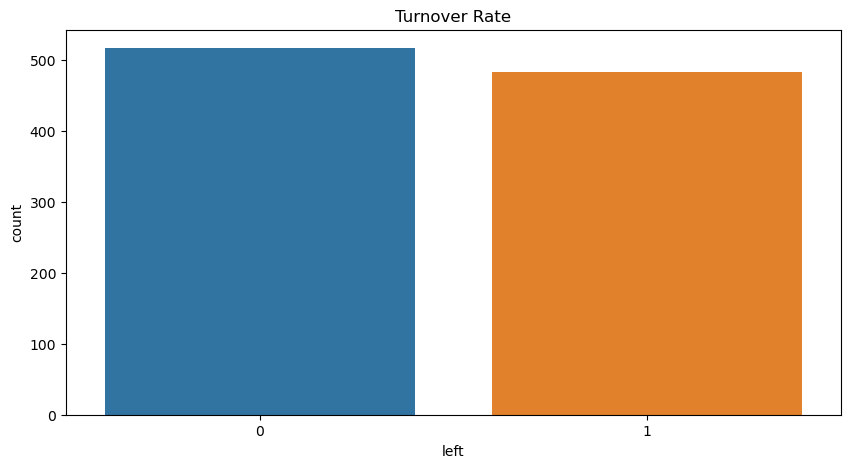

In [59]:
# Plot turnover rate
plt.figure(figsize=(10, 5))
sns.countplot(x='left', data=df)
plt.title('Turnover Rate')
plt.show()

## 2. Perform K-Means Clustering

/var/folders/lk/rsf38rvj3qj0tpdcgt79nwkm0000gn/T/ipykernel_42618/1730891556.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_left['cluster'] = kmeans.fit_predict(X)


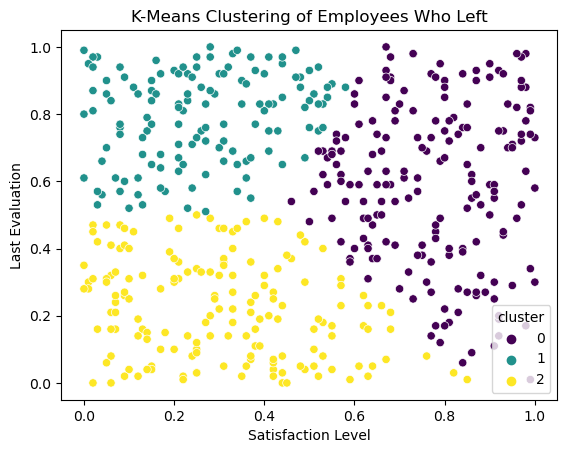

In [60]:
from sklearn.cluster import KMeans

# Filter employees who left
df_left = df[df['left'] == 1]

# Select features for clustering
X = df_left[['satisfaction_level', 'last_evaluation']]

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=0)
df_left['cluster'] = kmeans.fit_predict(X)


# Visualize the clusters
# plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_left, x='satisfaction_level', y='last_evaluation', hue='cluster', palette='viridis')
plt.title('K-Means Clustering of Employees Who Left')
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation')
plt.show()

# Visualize the clusters
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='satisfaction_level', y='last_evaluation', hue='cluster', data=df_left, palette='Set1')
# plt.title('K-Means Clustering of Employees Who Left')
# plt.show()

## 3. Handle Class Imbalance Using SMOTE

In [61]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

print('All packages for handling Class Imbalance imported successfully!')

All packages for handling Class Imbalance imported successfully!


In [62]:
df_categorical = df[categorical_vars]
df_numerical = df[numerical_vars]

# Apply get_dummies() to categorical variables. One-hot encode categorical variables
df_categorical_dummies = pd.get_dummies(df_categorical)

# Combine categorical and numerical variables
df_combined = pd.concat([df_numerical, df_categorical_dummies], axis=1)

# Separate features and target variable
X = df_combined.drop('left', axis=1)
y = df_combined['left']

# Check the balance of the new dataset
print("Before applying stratified split")
print(y.value_counts())


Before applying stratified split
left
0    517
1    483
Name: count, dtype: int64


### Do the stratified split of the dataset to train and test in the ratio 80:20 with random_state=123

In [63]:
# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=123)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the balance of the new dataset
print("After applying stratified split")
print(y_train_resampled.value_counts())

# Apply StandardScaler to the training and test sets
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
print(f"X_train_resampled_scaled shape: {X_train_resampled_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

After applying stratified split
left
0    414
1    414
Name: count, dtype: int64
X_train_resampled_scaled shape: (828, 20)
X_test_scaled shape: (200, 20)


## 4. Perform 5-Fold Cross-Validation and Model Evaluation

We'll train and evaluate Logistic Regression and Random Forest models using 5-fold cross-validation.

In [64]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, roc_auc_score

print('All packages for  5-fold cross-validatione imported successfully!')

All packages for  5-fold cross-validatione imported successfully!


### LogisticRegression using StratifiedKFold

In [65]:
# Initialize models 
log_reg = LogisticRegression(max_iter=10000,random_state=123)
rf = RandomForestClassifier(random_state=0)
gb_classifier = GradientBoostingClassifier(random_state=0)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# # Define scoring metric
scoring = make_scorer(roc_auc_score)

# Perform 5-fold cross-validation for Logistic Regression
log_reg_scores = cross_val_score(log_reg, X_train_resampled, y_train_resampled, cv=cv, scoring=scoring)
print("Logistic Regression AUC Scores:", log_reg_scores)
print("Logistic Regression Mean AUC Score:", log_reg_scores.mean())

# print("5-fold cross-validation after applying StandardScaler")
# Perform 5-fold cross-validation for Logistic Regression
# log_reg_scores_2 = cross_val_score(log_reg, X_train_resampled, y_train_resampled, cv=cv, scoring=scoring)
# print("Logistic Regression AUC Scores:", log_reg_scores_2)

# Perform 5-fold cross-validation for Random Forest
rf_scores = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=cv, scoring=scoring)
print("Random Forest AUC Scores:", rf_scores)
print("Random Forest Mean AUC Score:", rf_scores.mean())

Logistic Regression AUC Scores: [0.46987952 0.48192771 0.5        0.52071701 0.50308551]
Logistic Regression Mean AUC Score: 0.4951219512195122
Random Forest AUC Scores: [0.45180723 0.53012048 0.48795181 0.50881575 0.56384073]
Random Forest Mean AUC Score: 0.5085071995298266


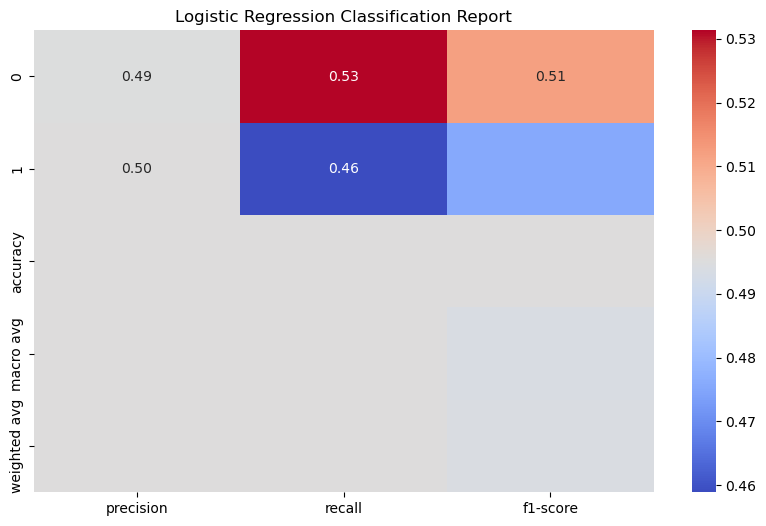

In [66]:

# Initialize lists to store classification reports
log_reg_reports = []
rf_reports = []
# Perform 5-fold cross-validation for Logistic Regression
for train_index, test_index in cv.split(X_train_resampled, y_train_resampled):
    X_train, X_test = X_train_resampled.iloc[train_index], X_train_resampled.iloc[test_index]
    y_train, y_test = y_train_resampled.iloc[train_index], y_train_resampled.iloc[test_index]
    
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    log_reg_reports.append(report)

def aggregate_reports(reports):
    """Aggregate multiple classification reports into a single report."""
    aggregated_report = {}
    for key in reports[0].keys():
        if isinstance(reports[0][key], dict):
            aggregated_report[key] = {metric: np.mean([r[key][metric] for r in reports]) for metric in reports[0][key].keys()}
        else:
            aggregated_report[key] = np.mean([r[key] for r in reports])
    return aggregated_report

def plot_classification_report(report, title):
    """Plot the classification report as a heatmap."""
    df_report = pd.DataFrame(report).iloc[:-1, :].T
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_report, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(title)
    plt.show()

    
 # Aggregate reports
log_reg_aggregated_report = aggregate_reports(log_reg_reports)

# Plot the classification reports
plot_classification_report(log_reg_aggregated_report, 'Logistic Regression Classification Report')   

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define model
model = RandomForestClassifier(random_state=42)

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform 5-fold cross-validation for Random Forest using KFold
cv_results = cross_val_score(model, X_train_resampled, y_train_resampled, cv=kf, scoring='accuracy')

# Perform 5-fold cross-validation for Random Forest
print(f'Random Forest accuracy scores: {cv_results}')
print(f'Random Forest accuracy: {cv_results.mean()}')

Random Forest accuracy scores: [0.57228916 0.46385542 0.51204819 0.46666667 0.53333333]
Random Forest accuracy: 0.5096385542168675


In [68]:
# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=123)

# Define models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=1000, random_state=123),
    'LogisticRegression': LogisticRegression(max_iter=10000, random_state=123),
    'GradientBoosting': GradientBoostingClassifier(random_state=123)
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}:")
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(f'Precision: {precision_score(y_test, y_pred):.4f}')
    print(f'Recall: {recall_score(y_test, y_pred):.4f}')
    print(f'F1 Score: {f1_score(y_test, y_pred):.4f}')


# Perform 5-fold cross-validation and evaluate performance for each model
for name, model in models.items():
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train_resampled_scaled, y_train_resampled, cv=5, scoring='roc_auc')
    print(f"\n{name}:")
    print(f"Cross-validation ROC AUC scores: {cv_scores}")
    print(f"Cross-validation Mean ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    # Train the model on the full training set
    model.fit(X_train_resampled_scaled, y_train_resampled)

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:,1]# Shape: (n_samples,) positve class probas
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"Prediction on test set, ROC AUC: {roc_auc:.4f}")    



RandomForest:
Accuracy: 0.5273
Precision: 0.5333
Recall: 0.4819
F1 Score: 0.5063

LogisticRegression:
Accuracy: 0.5030
Precision: 0.5062
Recall: 0.4940
F1 Score: 0.5000

GradientBoosting:
Accuracy: 0.5212
Precision: 0.5238
Recall: 0.5301
F1 Score: 0.5269


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000, random_state=123),
    'Random Forest': RandomForestClassifier(random_state=123),
    'Gradient Boosting': GradientBoostingClassifier(random_state=123)
}

# Perform 5-fold cross-validation and evaluate performance for each model
for name, model in models.items():
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train_resampled_scaled, y_train_resampled, cv=5, scoring='roc_auc')
    print(f"\n{name}:")
    print(f"Cross-validation ROC AUC scores: {cv_scores}")
    print(f"Cross-validation Mean ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    # Train the model on the full training set
    model.fit(X_train_resampled_scaled, y_train_resampled)

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:,1]# Shape: (n_samples,) positve class probas